# 📚 Discovering Book Micro-Genres with Unsupervised Learning

The goal is to identify hidden micro-genres by clustering books based on the words in their descriptions. 
Using unsupervised learning and KMeans clustering, we group similar books without relying on labeled genres. 
Descriptions are transformed into numerical features using TF-IDF vectorization.


## 🔍 Step 1: Define the Problem

Can we find clusters of similar books based on the presence of common words in their descriptions?

This task is suitable for **unsupervised learning** because we don't have labeled genres.


In [ ]:
# Necessary libraries

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import string

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

## 📂 Step 2: Load and Explore the Data

We use a book dataset with fields like title, author, and summary.
Only the `title` and `summary` columns are used for clustering.

Below is a sample of the data and basic info:


In [4]:
from datasets import load_dataset

dataset = load_dataset('BrightData/Goodreads-Books')

README.md: 0.00B [00:00, ?B/s]

Goodreads-Books.csv:   0%|          | 0.00/8.29G [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Loading dataset shards:   0%|          | 0/17 [00:00<?, ?it/s]

## <a id="id5">Exploratory Data Analysis (EDA)</a>

In [44]:
dataset

Dataset({
    features: ['url', 'id', 'name', 'author', 'star_rating', 'num_ratings', 'num_reviews', 'summary', 'genres', 'first_published', 'about_author', 'community_reviews', 'kindle_price'],
    num_rows: 6389859
})

In [35]:
dataset = dataset['train']
Data= dataset.select_columns(["name", "summary"]).to_pandas()
Data = Data.rename(columns={"name": "title", "summary": "description"})


In [36]:
Data.head()

,title,description,genre
0,"Horror Film Directors, 1931-1990",An exhaustive study of the major directors of ...,2
1,"Australian Urban Planning: New Challenges, New...","Designed for use by academics, students, plann...",2
2,Morgen ohne gestern: Roman,Christine Hoffmann wacht eines Morgens im Kran...,1
3,Zen and the Art of Recording,"In this book, the third in the Zen and the Art...",2
4,The Big Book Of Codewords,500 codeword puzzles in one great book!,1


In [37]:
# print the null count for each column
print(Data.isna().sum())

title          0
description    0
genre          0
dtype: int64


In [38]:
Data = Data.dropna()

### 🧹 Text Cleaning and Preprocessing

We apply the following steps to prepare the text:
- Convert to lowercase
- Remove stopwords (e.g., "a", "the", "and")
- Lemmatize words (reduce to base form)

This ensures the descriptions are clean and consistent for vectorization.


In [11]:
nltk.download("stopwords")
nltk.download("wordnet")

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [13]:
stopWords = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

In [16]:
def preprocessText(txt):
    txt = txt.lower()
    token_txt = word_tokenize(txt)
    

    filtered_tokens = [
        word for word in token_txt 
        if word not in stopWords 
    ]
    
    lemmatized_tokens = [lemmatizer.lemmatize(token, pos='v') for token in filtered_tokens]
    
    return ' '.join(lemmatized_tokens)


In [39]:
Data['description'].apply(preprocessText)

0      An exhaustive study of the major directors of ...
1      Designed for use by academics, students, plann...
2      Christine Hoffmann wacht eines Morgens im Kran...
3      In this book, the third in the Zen and the Art...
4                500 codeword puzzles in one great book!
                             ...                        
995    Il ricchissimo signor Koike fa riattivare Indi...
996    En teoretisk indføring i fantasygenren samt en...
997    One of the most widely read German authors in ...
998    In this unusual dictionary, it is the meanings...
999    It is commonly supposed that certain elements ...
Name: description, Length: 903, dtype: object

### 🔢 Text Vectorization (TF-IDF)

We use **TF-IDF vectorization** to convert the cleaned book descriptions into numerical features.
This allows the clustering algorithm to compare books based on word importance.


In [40]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(Data['description'])

## 🔗 Step 3: Apply KMeans Clustering

We apply the KMeans algorithm to group books into clusters based on their TF-IDF vectors.

Each cluster represents a group of books with similar themes or topics — what we call **micro-genres**.


In [41]:
k = 3 
model = KMeans(n_clusters=k, random_state=42)
Data["genre"] = model.fit_predict(X)

/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


### 🗺️  Visualize Clusters (PCA)

We reduce the TF-IDF vectors to 2D using PCA and plot the clusters to visualize how the books are grouped.


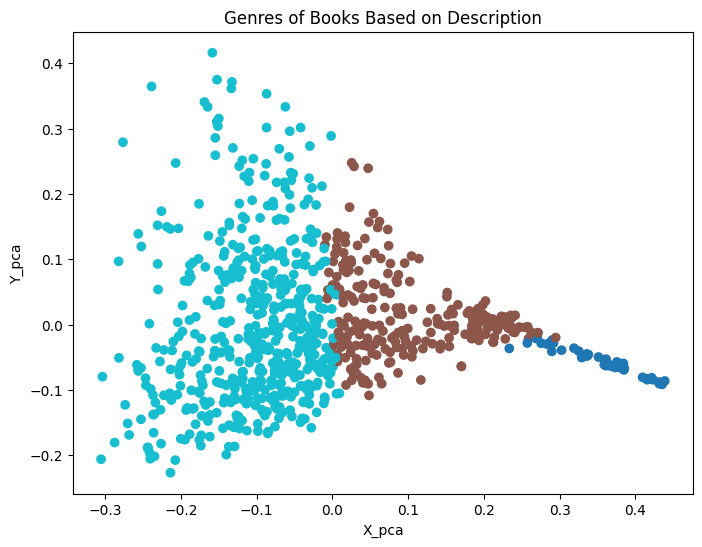

In [42]:
X_pca = PCA(n_components=2).fit_transform(X.toarray())

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c = Data["genre"], cmap = "tab10")
plt.title("Genres of Books Based on Description")
plt.xlabel("X_pca")
plt.ylabel("Y_pca")
plt.show()


## 📊 Step 4: Evaluate Clustering

We use the **Silhouette Score** to evaluate the quality of the clustering.
A higher score indicates well-defined, separate clusters.

(Current Score: 0.011 — suggests improvement is needed.)


In [43]:
score = silhouette_score(X, Data["genre"])
print(f"Silhouette Score: {score}")

Silhouette Score: 0.023304060272188423


### 💾 Save Results to CSV

We save the clustered data to a CSV file for further exploration, analysis, or use in other systems.


In [25]:
Data.to_csv("Book's_genre.csv", index=False)

### ✅ Conclusion

- We explored whether book descriptions can reveal hidden micro-genres using clustering.
- Text preprocessing and TF-IDF allowed us to convert descriptions into numerical features.
- KMeans grouped the books, but evaluation shows clustering can be improved.
- Future work: Try more clusters, better text cleaning, or advanced models like LDA or embeddings.
